In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

# Add line profiler
%load_ext line_profiler

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import subprocess
import os
import gc
import datetime
import importlib
import logging

import pycuda.driver as cuda
import pycuda.compiler

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
#Set large figure sizes
#Note, this prevents nice figures for articles...
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

from GPUSimulators import Common, IPythonMagic

In [2]:
%setup_logging --out test_schemes.log

Console logger using level INFO
File logger using level DEBUG to test_schemes.log
Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [3]:
%cuda_context_handler my_context

Registering my_context in user workspace
PyCUDA version 2017.1.1
CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
Created context handle <949373898256>
Using CUDA cache dir c:\Users\anbro\Documents\projects\GPUSimulators\GPUSimulators\cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience


In [4]:
def gen_test_data(nx, ny, g):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10

    h  = np.zeros((ny, nx), dtype=np.float32); 
    hu = np.zeros((ny, nx), dtype=np.float32);
    hv = np.zeros((ny, nx), dtype=np.float32);

    extent = 1.0/np.sqrt(2.0)
    x = (dx*(np.arange(0, nx, dtype=np.float32)+0.5) - x_center) / size
    y = (dy*(np.arange(0, ny, dtype=np.float32)+0.5) - y_center) / size
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    r = np.minimum(1.0, np.sqrt(xv**2 + yv**2))
    xv = None
    yv = None
    gc.collect()

    #Generate highres
    cos = np.cos(np.pi*r)
    h = 0.5 + 0.1*0.5*(1.0 + cos)
    hu = 0.1*0.5*(1.0 + cos)
    hv = hu.copy()

    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1*np.sqrt(2.0)
    dx = width/nx
    dy = height/ny
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

    return h, hu, hv, dx, dy, dt

In [5]:
#%lprun -f gen_test_data gen_test_data(100, 150, 2)

In [6]:
nx = 1000
ny = 1500
nx_halo = 2
ny_halo = 3
a = np.random.rand(ny, nx).astype(np.float32)

import pycuda.driver as cuda
stream = cuda.Stream()

with Common.Timer("upload (async)") as t:
    a_gpu = Common.CudaArray2D(stream, nx, ny, nx_halo, ny_halo, a)

with Common.Timer("download (async)") as t:
    b = a_gpu.download(stream, async=True)
    
with Common.Timer("sync") as t:
    cuda.Context.synchronize()
    
print("Sum of absolute difference: ", np.sum(np.abs(a-b)))

Sum of absolute difference:  0.0


In [7]:
#%lprun -f Common.get_kernel Common.get_kernel("FORCE_kernel.cu", 16, 16)

In [8]:
nx = 256
ny = 128
g = 9.81

h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ny, g)

arguments = {
    'context': my_context,
    'h0': h0, 'hu0': hu0, 'hv0': hv0,
    'nx': nx, 'ny': ny,
    'dx': dx, 'dy': dy, 'dt': 0.9*dt,
    'g': g
} 

t_end = 20

LxF [256x128] simulated 20.000000 seconds to 20.000000 with 209 steps (Euler)


0.5450979
0.48743016


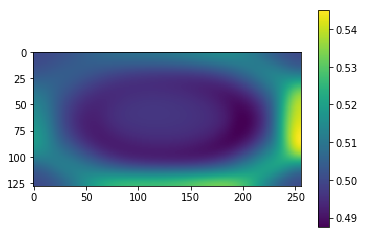

In [9]:
from GPUSimulators import LxF
importlib.reload(LxF)

with Common.Timer("construct") as t:
    sim = LxF.LxF(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

print(h1.max())
print(h1.min())

FORCE [256x128] simulated 20.000000 seconds to 20.000000 with 209 steps (Euler)


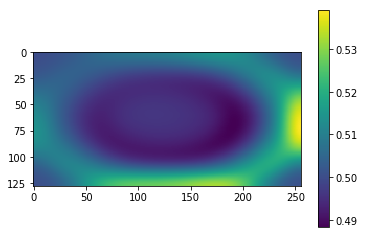

In [10]:
from GPUSimulators import FORCE
importlib.reload(FORCE)

with Common.Timer("construct") as t:
    sim = FORCE.FORCE(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

HLL [256x128] simulated 20.000000 seconds to 20.000000 with 209 steps (Euler)


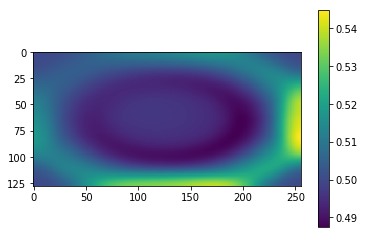

In [11]:
from GPUSimulators import HLL
importlib.reload(HLL)

with Common.Timer("construct") as t:
    sim = HLL.HLL(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

HLL2 [256x128] simulated 20.000000 seconds to 20.000000 with 210 steps (dimsplit)


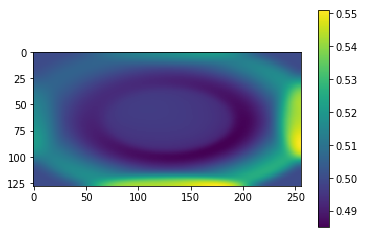

In [12]:
from GPUSimulators import HLL2
importlib.reload(HLL2)

with Common.Timer("construct") as t:
    sim = HLL2.HLL2(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

KP07 [256x128] simulated 20.000000 seconds to 20.000000 with 209 steps (RK2)


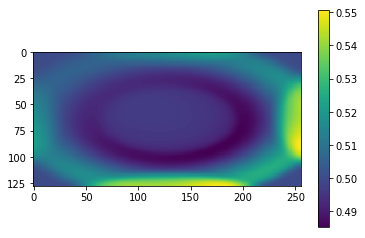

In [13]:
from GPUSimulators import KP07
importlib.reload(KP07)

with Common.Timer("construct") as t:
    sim = KP07.KP07(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

KP07_dimsplit [256x128] simulated 20.000000 seconds to 20.000000 with 210 steps (dimsplit)


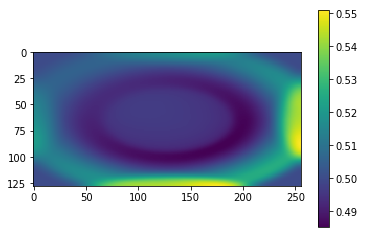

In [14]:
from GPUSimulators import KP07_dimsplit
importlib.reload(KP07_dimsplit)

with Common.Timer("construct") as t:
    sim = KP07_dimsplit.KP07_dimsplit(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()

WAF [256x128] simulated 20.000000 seconds to 20.000000 with 210 steps (dimsplit)


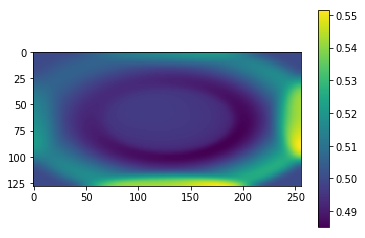

In [15]:
from GPUSimulators import WAF
importlib.reload(WAF)

with Common.Timer("construct") as t:
    sim = WAF.WAF(**arguments)

with Common.Timer("step") as t:
    t = sim.simulate(t_end)
    
with Common.Timer("download") as t:
    h1, hu1, hv1 = sim.download()

plt.figure()
plt.imshow(h1)
plt.colorbar()